In [ ]:
!pip install rdkit
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost
!pip install joblib

^C


In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from xgboost import XGBRegressor
import joblib
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

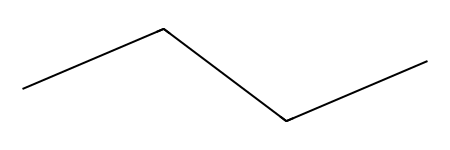

In [2]:
mol = Chem.MolFromSmiles('CCCC')
mol

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_dataset(file_path):
    """
    Loads the dataset from a CSV file and returns:
      - X: features from columns C to Q (15 columns)
      - y: target from column R (Enhancement Factor)
      - feature_cols: list of feature names
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)
    print(df.head(17))

    # Adjust indexing if needed. Here we assume:
    #   - Column C -> index 2
    #   - Column Q -> index 16
    #   - Column R -> index 17 (Enhancement Factor)
    feature_cols = df.columns[2:17]  # 15 feature columns
    target_col = df.columns[17]      # Enhancement Factor

    X = df[feature_cols].values
    y = df[target_col].values

    return X, y, feature_cols

def train_xgboost_model(X, y, test_size=0.2, random_state=42, scale_features=True):
    """
    Splits data, optionally scales features, and trains an XGBoost Regressor.

    Parameters
    ----------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features).
    y : numpy.ndarray
        Target array of shape (n_samples,).
    test_size : float
        Fraction of data to reserve for testing.
    random_state : int
        Seed for reproducible train-test splitting and model randomness.
    scale_features : bool
        If True, applies standard scaling to features.

    Returns
    -------
    model : XGBRegressor
        Trained XGBoost regression model.
    X_test_scaled : numpy.ndarray
        Scaled test feature matrix (for predictions).
    y_test : numpy.ndarray
        True target values for the test set.
    scaler : StandardScaler or None
        The fitted scaler if scale_features=True, otherwise None.
    """
    # 1. Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )

    # 2. (Optional) feature scaling
    scaler = None
    if scale_features:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    # 3. Initialize and train XGBoost Regressor
    #    Basic parameters can be tuned further for small datasets
    model = XGBRegressor(
        n_estimators=100,
        random_state=random_state
    )
    model.fit(X_train_scaled, y_train)

    return model, X_test_scaled, y_test, scaler

def evaluate_model(model, X_test, y_test):
    """
    Computes and prints multiple performance metrics:
    - MSE, RMSE, MAE
    - R²
    - Adjusted R²
    """
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Adjusted R²
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else None

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    if adjusted_r2 is not None:
        print(f"Adjusted R² Score: {adjusted_r2:.4f}")
    else:
        print("Adjusted R² Score: Not defined (n <= p + 1).")

def predict_enhancement(model, input_features, scaler=None):
    """
    Predicts the 'Enhancement Factor' for new input data.

    Parameters
    ----------
    model : XGBRegressor
        A trained XGBoost regression model.
    input_features : array-like of shape (n_samples, n_features)
        The new data points for which to predict the Enhancement Factor.
    scaler : StandardScaler or None
        If the model was trained with scaling, pass the fitted scaler here.

    Returns
    -------
    predictions : numpy.ndarray
        Predicted Enhancement Factor values.
    """
    # Apply scaling if needed
    if scaler is not None:
        input_features = scaler.transform(input_features)

    predictions = model.predict(input_features)
    return predictions

if __name__ == "__main__":
    # 1. Load dataset
    csv_file = "drug_descriptors.csv"  # Replace with your actual CSV file path
    X, y, feature_cols = load_dataset(csv_file)

    # 2. Train XGBoost model
    model, X_test_scaled, y_test, scaler = train_xgboost_model(
        X, y,
        test_size=0.2,        # 80% train, 20% test
        random_state=42,      # For reproducibility
        scale_features=True   # Apply standard scaling
    )

    # 3. Evaluate model
    evaluate_model(model, X_test_scaled, y_test)

    # 4. Predict Enhancement Factor for new data (example)
    new_data = np.array([
        [1606.29, 0.41483, 0.07137, 0.3726, 12.8, 1.29, 0.11, 0.23, 5.52, 0.33,
         0.1, 1, 0, 0, 1]  # Example placeholders for 15 features
    ])
    prediction = predict_enhancement(model, new_data, scaler=scaler)
    print("\nPredicted Enhancement Factor:", prediction)


    ID                                             Smiles MolWeight  \
0    1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O   1606.29   
1    2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...   1527.47   
2    3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O   1466.35   
3    4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O   1762.46   
4    5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2   250.323   
5    6  CC(C)C[C@H](C(=O)NCc1ccc(cc1)c1ccccc1C(=N)N=N)...    1570.5   
6    7  CCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])C)...      1846   
7    8  COCCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])...    418.44   
8    9                       O=C1Nc2ccccc2C2=CC=CC=C2C1=O  1371.25    
9   10  CC1=NC(C)=NC(OCC2CCC(OC3=NC(N4CCN(C)CC4)=NC(C4...    1840.6   
10  11  CC(C)CC(CC=C)C(=O)OC[C@@H]1CC[C@@H](CC1)C(=O)O...   1553.55   
11  12      COc1ccc(cc1)/C=C/C(=O)CC(=O)/C=C/c1ccc(cc1)OC   1503.36   
12  13      COc1ccc2c(c1)n(c(c2C(=O)O)C(=O)c1ccc(cc1)Cl)C    1492.8   
13  14

Here is an improved version of this model:
-
-
-
-
-
-
-
-
-


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint

def load_dataset(file_path):
    """
    Loads the dataset from a CSV file, assuming:
      - 15 features in columns C->Q (indices 2:17)
      - 'Enhancement Factor' in column R (index 17).
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)
    print(df.head(17))
    
    feature_cols = df.columns[2:17]   # 15 columns for features
    target_col = df.columns[17]      # 'Enhancement Factor'
    X = df[feature_cols].values
    y = df[target_col].values
    return X, y, feature_cols

def create_scaler(X):
    """
    Creates and fits a StandardScaler, returns the scaler and transformed data.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return scaler, X_scaled

def custom_metrics_cv(model, X, y):
    """
    A helper function to compute multiple metrics (R², MSE, MAE) on predictions.
    This can be used after cross-validation to evaluate the best model.
    """
    predictions = model.predict(X)
    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

def main():
    # 1. Load the dataset
    csv_file = "drug_descriptors.csv"  # Replace with your actual CSV path
    X, y, feature_cols = load_dataset(csv_file)
    
    # 2. (Optional) Scale the features
    scaler, X_scaled = create_scaler(X)
    
    # 3. Define parameter distributions for RandomizedSearchCV
    #    We keep the range small due to the limited data.
    param_distributions = {
        'max_depth': randint(2, 7),
        'learning_rate': uniform(0.01, 0.3),   # Range: [0.01, 0.31)
        'n_estimators': randint(50, 300),
        'subsample': uniform(0.6, 0.4),        # Range: [0.6, 1.0)
        'colsample_bytree': uniform(0.6, 0.4), # Range: [0.6, 1.0)
        'min_child_weight': randint(1, 6)
    }
    
    # 4. Set up Leave-One-Out CV (or use KFold(n_splits=5))
    loo = LeaveOneOut()
    
    # 5. Initialize XGBRegressor
    xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)
    
    # 6. Define a scoring function (we'll use R² for maximizing).
    #    If you prefer to minimize MSE, you could do scoring='neg_mean_squared_error'.
    scoring = 'r2'
    
    # 7. RandomizedSearchCV to search hyperparams
    #    n_iter controls how many random combos we try
    #    Increase n_iter if you want a more exhaustive search.
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_distributions,
        n_iter=30,
        scoring='r2',  # Now valid because each fold has >1 test sample
        cv=kfold,
        random_state=42,
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    
    # 8. Fit the random search
    random_search.fit(X_scaled, y)
    
    print("\nBest Hyperparameters found:")
    print(random_search.best_params_)
    print(f"Best R² from CV: {random_search.best_score_:.4f}")
    
    # 9. The best model is automatically refit on the entire CV dataset
    best_model = random_search.best_estimator_
    
    # 10. Evaluate the best model on the entire dataset (or do a new train-test split if you prefer)
    print("\nPerformance of best model on the entire dataset:")
    custom_metrics_cv(best_model, X_scaled, y)
    
    # 11. Example: Predict Enhancement Factor for new data
    #     Suppose we have one new sample of 15 features:
    new_data = np.array([[1606.29, 0.41483, 0.07137, 0.3726, 12.8, 1.29, 0.11,
                          0.23, 5.52, 0.33, 0.1, 1, 0, 0, 1]])
    new_data_scaled = scaler.transform(new_data)
    prediction = best_model.predict(new_data_scaled)
    print(f"\nPredicted Enhancement Factor for new sample: {prediction[0]:.4f}")

if __name__ == "__main__":
    main()


    ID                                              Smiles  MolWeight  \
0     1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O    206.285   
1     2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...    380.412   
2     3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O    229.217   
3     4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O    298.379   
4     5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2    250.323   
5     6  CC(C)C[C@H](C(=O)NCc1ccc(cc1)c1ccccc1C(=N)N=N)...    451.527   
6     7  CCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])C)...    374.393   
7     8  COCCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])...    434.445   
8     9                       O=C1Nc2ccccc2C2=CC=CC=C2C1=O    223.231   
9    10  CC1=NC(C)=NC(OCC2CCC(OC3=NC(N4CCN(C)CC4)=NC(C4...    559.502   
10   11  CC(C)CC(CC=C)C(=O)OC[C@@H]1CC[C@@H](CC1)C(=O)O...    338.488   
11   12      COc1ccc(cc1)/C=C/C(=O)CC(=O)/C=C/c1ccc(cc1)OC    336.387   
12   13      COc1ccc2c(c1)n(c(c2C(=O)O)C(=O)c1ccc(c

Now we conduct feature analysis and data visulualisation:
- - 
-
-
-
-
-


Data Preview:
    ID                                              Smiles  MolWeight  \
0     1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O    206.285   
1     2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...    380.412   
2     3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O    229.217   
3     4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O    298.379   
4     5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2    250.323   
5     6  CC(C)C[C@H](C(=O)NCc1ccc(cc1)c1ccccc1C(=N)N=N)...    451.527   
6     7  CCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])C)...    374.393   
7     8  COCCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])...    434.445   
8     9                       O=C1Nc2ccccc2C2=CC=CC=C2C1=O    223.231   
9    10  CC1=NC(C)=NC(OCC2CCC(OC3=NC(N4CCN(C)CC4)=NC(C4...    559.502   
10   11  CC(C)CC(CC=C)C(=O)OC[C@@H]1CC[C@@H](CC1)C(=O)O...    338.488   
11   12      COc1ccc(cc1)/C=C/C(=O)CC(=O)/C=C/c1ccc(cc1)OC    336.387   
12   13      COc1ccc2c(c1)n(c(c2C(=O

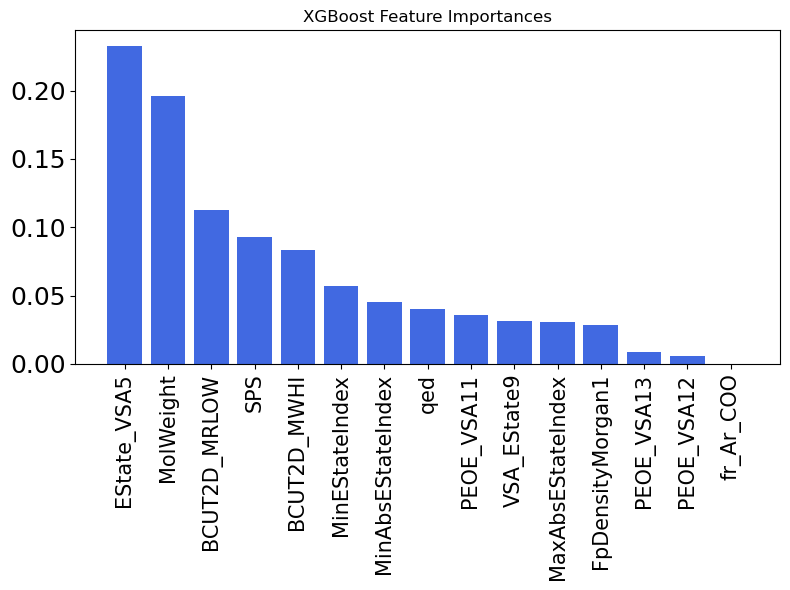

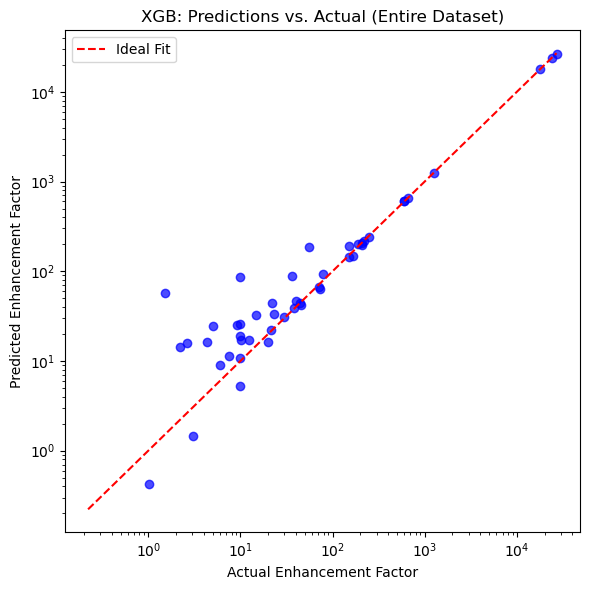

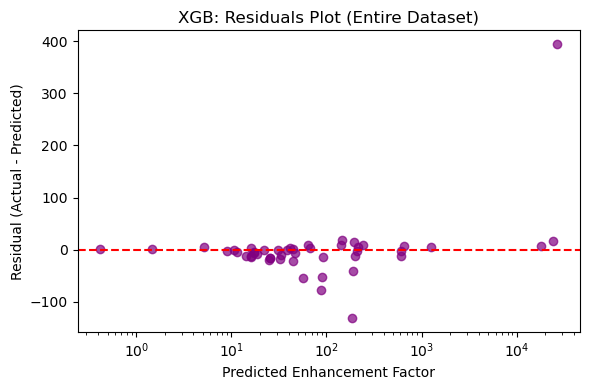


Predicted Enhancement Factor for new sample: 12701.8008


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

# ------------------------------
# 1. LOAD DATASET
# ------------------------------
def load_dataset(file_path):
    """
    Loads the dataset from a CSV file, assuming:
      - 15 features in columns C->Q (indices 2:17)
      - 'Enhancement Factor' in column R (index 17).
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)
    print("\nData Preview:")
    print(df.head(len(df)))  # Show entire dataset if small; or just head()

    # Adjust these indices if your CSV differs
    feature_cols = df.columns[2:17]   # 15 columns for features
    target_col = df.columns[17]      # 'Enhancement Factor'

    X = df[feature_cols].values
    y = df[target_col].values
    return X, y, feature_cols

# ------------------------------
# 2. SCALER CREATION
# ------------------------------
def create_scaler(X):
    """
    Creates and fits a StandardScaler, returns the scaler and transformed data.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return scaler, X_scaled

# ------------------------------
# 3. CUSTOM METRICS
# ------------------------------
def custom_metrics_cv(model, X, y):
    """
    Computes multiple metrics (R², MSE, RMSE, MAE) on predictions.
    Useful after cross-validation to evaluate the best model.
    """
    predictions = model.predict(X)
    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    
    print(f"R²:  {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE:{rmse:.4f}")
    print(f"MAE: {mae:.4f}")

# ------------------------------
# 4. VISUALIZATIONS
# ------------------------------
def plot_feature_importances(model, feature_cols, max_features=None):
    """
    Plots feature importances from the fitted XGBoost model.
    By default, XGBRegressor.feature_importances_ uses 'weight' (split count).
    """
    importances = model.feature_importances_
    # Pair each importance with its feature name
    importance_pairs = list(zip(feature_cols, importances))
    # Sort descending
    importance_pairs.sort(key=lambda x: x[1], reverse=True)

    # Optionally limit the number of features displayed
    if max_features is not None:
        importance_pairs = importance_pairs[:max_features]

    labels, scores = zip(*importance_pairs)

    plt.figure(figsize=(8, 6))
    plt.title("XGBoost Feature Importances")
    plt.bar(range(len(scores)), scores, color="royalblue")
    plt.xticks(range(len(scores)), labels, rotation=90, fontsize=15)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(model, X, y, title="Predictions vs. Actual"):
    """
    Scatter plot of actual vs. predicted values.
    Also draws a y=x reference line.
    """
    predictions = model.predict(X)
    plt.figure(figsize=(6, 6))
    plt.scatter(y, predictions, color='blue', alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()],
             color='red', linestyle='--', label='Ideal Fit')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Actual Enhancement Factor")
    plt.ylabel("Predicted Enhancement Factor")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_residuals(model, X, y, title="Residuals Plot"):
    """
    Residuals plot: predicted vs. (y_test - y_pred).
    Helps visualize how predictions deviate from actual.
    """
    predictions = model.predict(X)
    residuals = y - predictions
    plt.figure(figsize=(6, 4))
    plt.scatter(predictions, residuals, color='purple', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xscale('log')
    plt.xlabel("Predicted Enhancement Factor")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ------------------------------
# 5. MAIN PIPELINE
# ------------------------------
def main():
    # 1. Load the dataset
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)  # Replace with your actual CSV path
    X, y, feature_cols = load_dataset(file_path)
    
    # 2. Scale the features (optional, but recommended for many ML algorithms)
    scaler, X_scaled = create_scaler(X)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size=0.2,
        random_state=42
    )
    
    # 3. Define parameter distributions for RandomizedSearchCV
    #    This helps find a better hyperparameter combo for small data
    param_distributions = {
        'max_depth': randint(2, 7),
        'learning_rate': uniform(0.01, 0.3),
        'n_estimators': randint(50, 300),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'min_child_weight': randint(1, 6)
    }

    # 4. Choose cross-validation strategy
    #    With 16 data points, K=5 is a balance; or consider LeaveOneOut
    from sklearn.model_selection import KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # 5. Initialize XGBRegressor
    from xgboost import XGBRegressor
    xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

    # 6. RandomizedSearchCV for hyperparameter tuning
    from sklearn.model_selection import RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_distributions,
        n_iter=30,
        scoring='r2',  # aiming to maximize R²
        cv=kfold,
        random_state=42,
        n_jobs=-1,
        verbose=1,
        refit=True
    )

    # 7. Fit the random search on the entire dataset
    random_search.fit(X_scaled, y)
    
    print("\nBest Hyperparameters found:")
    print(random_search.best_params_)
    print(f"Best R² from CV: {random_search.best_score_:.4f}")

    # 8. Extract the best model (already refit on entire dataset)
    best_model = random_search.best_estimator_

    print("\n=== TRAINING-SET PERFORMANCE ===")
    custom_metrics_cv(best_model, X_train, y_train)

    # 10. Evaluate on the **test** set
    print("\n=== TEST-SET PERFORMANCE ===")
    custom_metrics_cv(best_model, X_test, y_test)

    # 9. Evaluate the best model on the entire dataset
    print("\nPerformance of best model on the entire dataset:")
    custom_metrics_cv(best_model, X_scaled, y)

    # 10. Visualize feature importance
    plot_feature_importances(best_model, feature_cols, max_features=15)

    # 11. Additional plots: Predictions vs. Actual, Residuals
    plot_predictions_vs_actual(best_model, X_scaled, y, 
                               title="XGB: Predictions vs. Actual (Entire Dataset)")
    plot_residuals(best_model, X_scaled, y, 
                   title="XGB: Residuals Plot (Entire Dataset)")

    # 12. Example: Predict Enhancement Factor for new data
    new_data = np.array([[1606.29, 0.41483, 0.07137, 0.3726, 12.8, 1.29, 0.11,
                          0.23, 5.52, 0.33, 0.1, 1, 0, 0, 1]])
    new_data_scaled = scaler.transform(new_data)
    prediction = best_model.predict(new_data_scaled)
    print(f"\nPredicted Enhancement Factor for new sample: {prediction[0]:.4f}")

if __name__ == "__main__":
    main()



Starting XGBoost SHAP Analysis for Molecular Enhancement Factor Prediction

Data Preview:
   ID            Name  Enhancement Factor  No. of OH-  EState_VSA5  MolWeight  \
0   1       Ibuprofen            30.00000           1      5.56345    206.285   
1   2   Dexamethasone            10.00000           3      6.92374    380.412   
2   3       Piroxicam             4.34783           1     13.24450    229.217   
3   4  Hydrocortisone            71.40000           3      6.92374    298.379   
4   5     Albendazole           600.00000           0      7.10980    250.323   

   logP    TPSA  No. of Phenyl Rings  No. of COOH  
0  3.64   37.30                    1            1  
1  1.14   94.83                    0            0  
2  3.07  111.47                    1            0  
3  0.55   94.83                    0            0  
4  2.90   92.30                    1            0  

Feature Statistics:
       No. of OH-  EState_VSA5    MolWeight       logP        TPSA  \
count   51.000000   

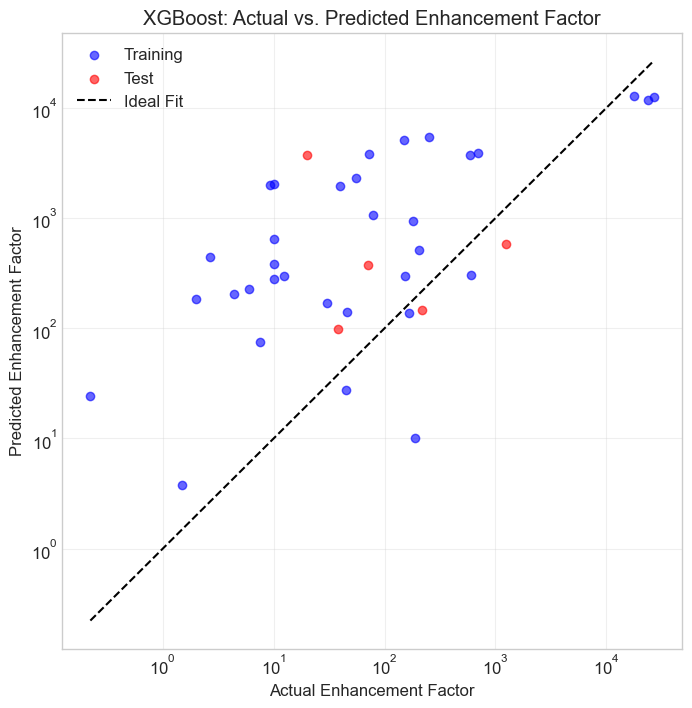

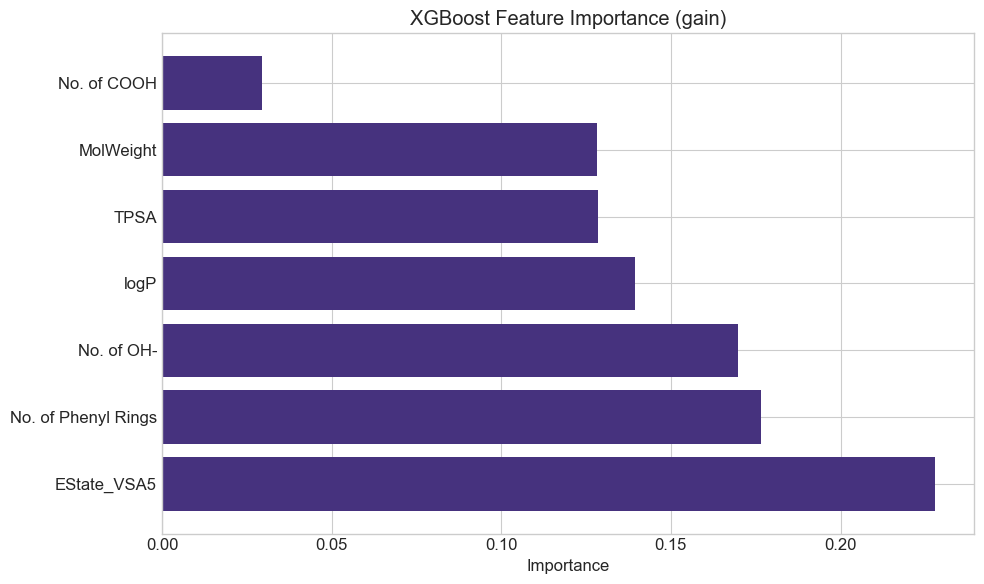


Performing SHAP analysis...


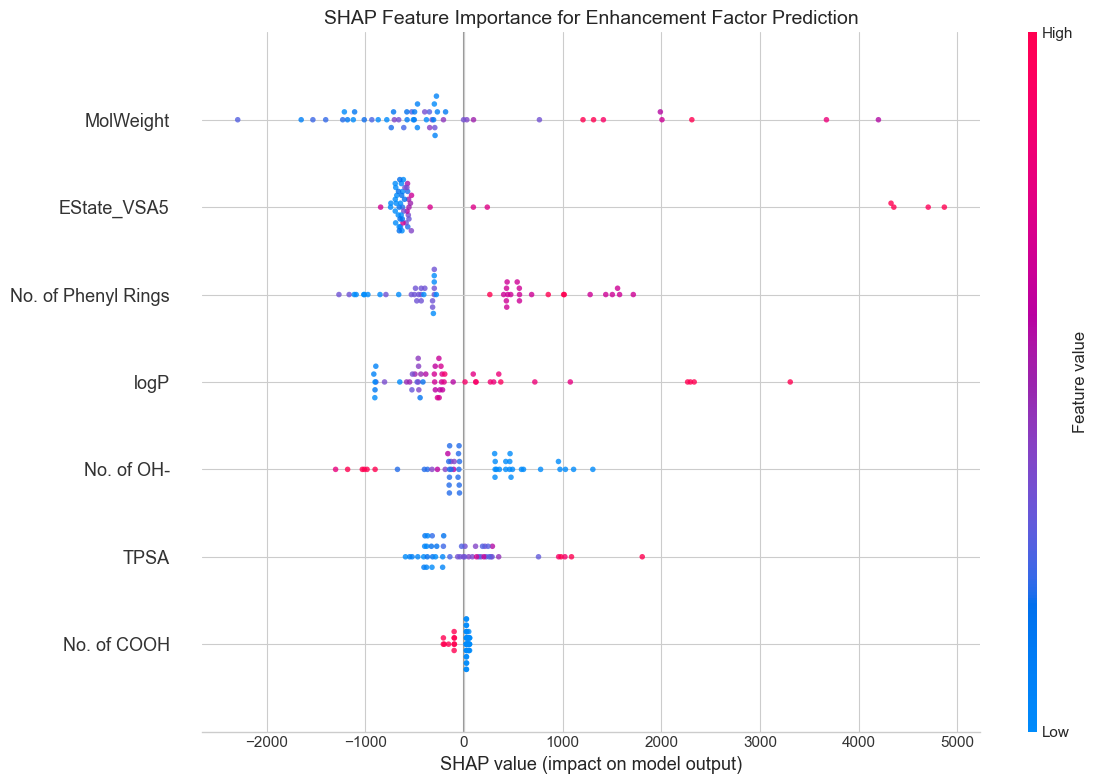

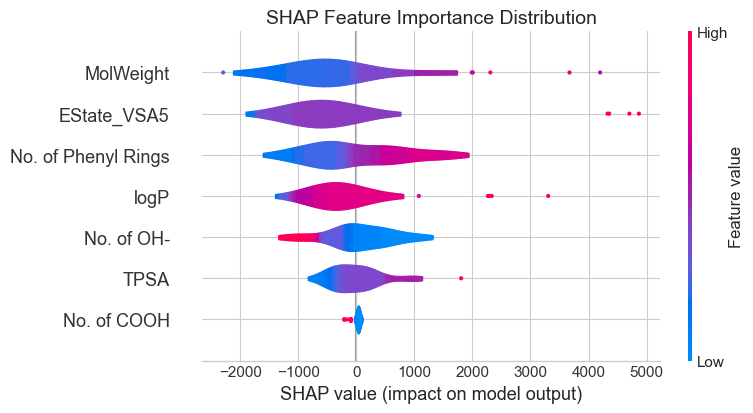

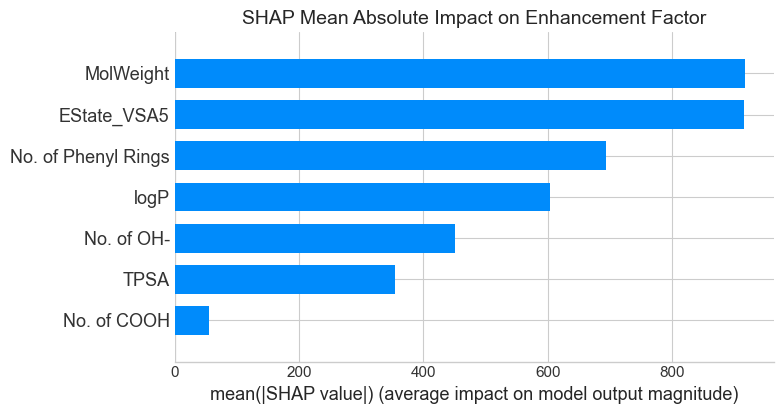

<Figure size 1000x600 with 0 Axes>

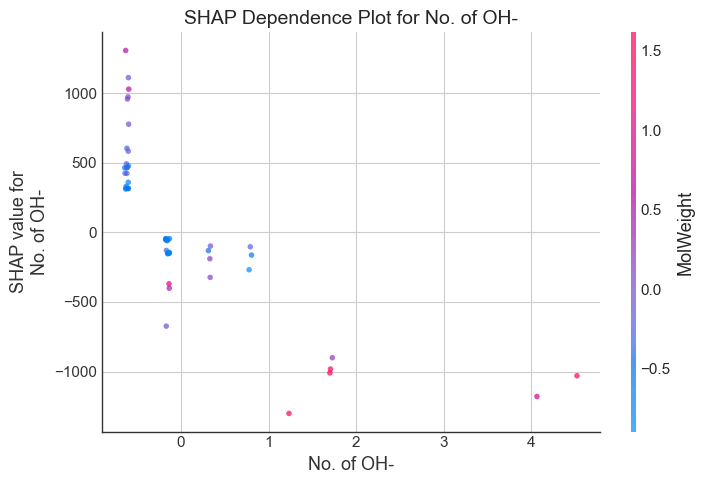

<Figure size 1000x600 with 0 Axes>

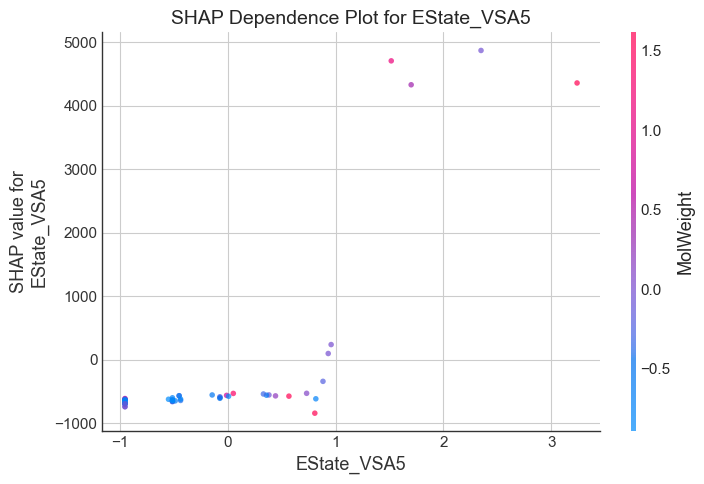

<Figure size 1000x600 with 0 Axes>

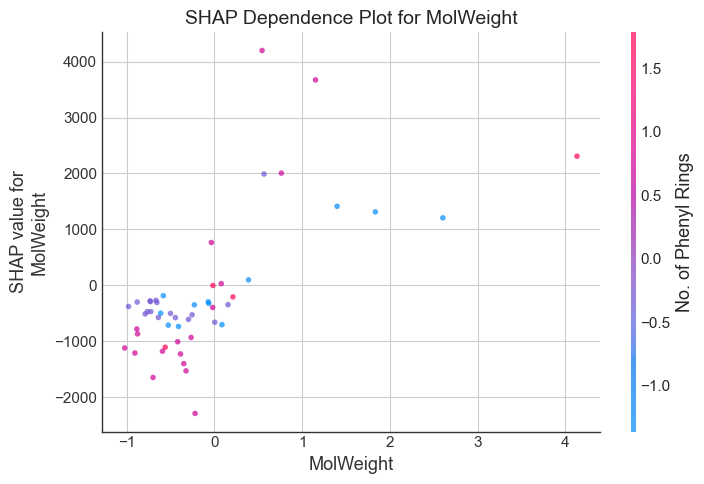

<Figure size 1000x600 with 0 Axes>

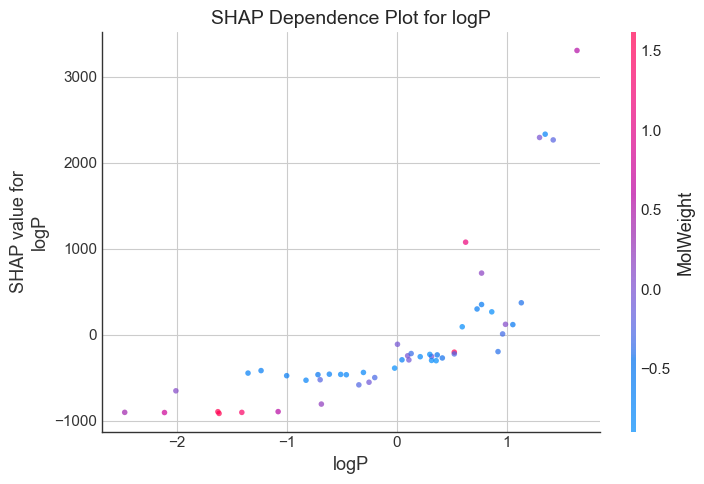

<Figure size 1000x600 with 0 Axes>

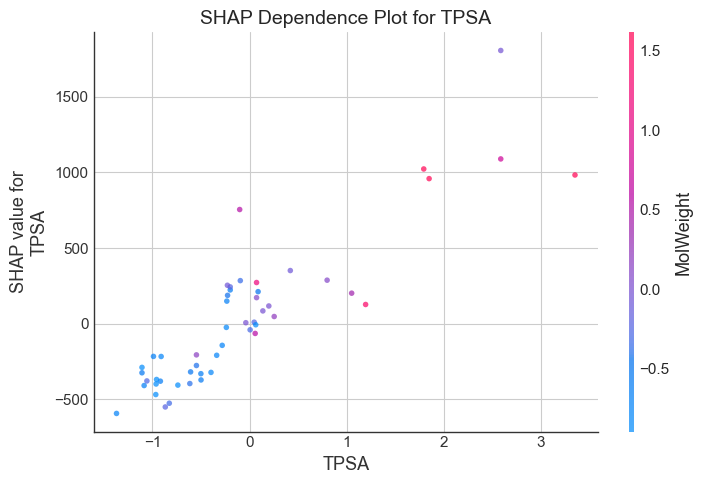

<Figure size 1000x600 with 0 Axes>

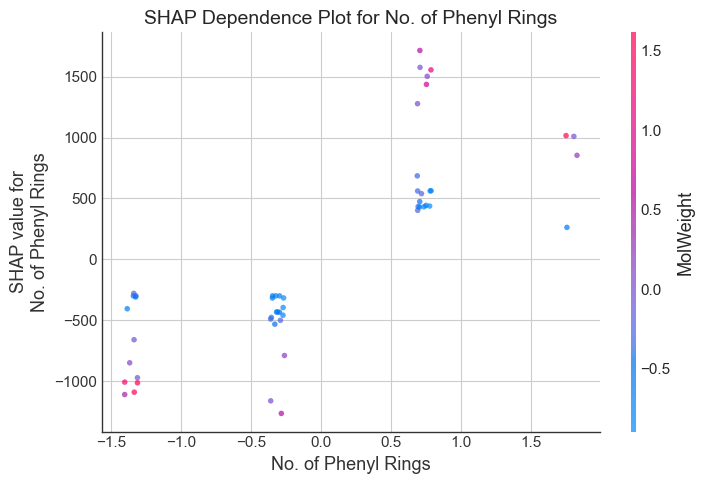

<Figure size 1000x600 with 0 Axes>

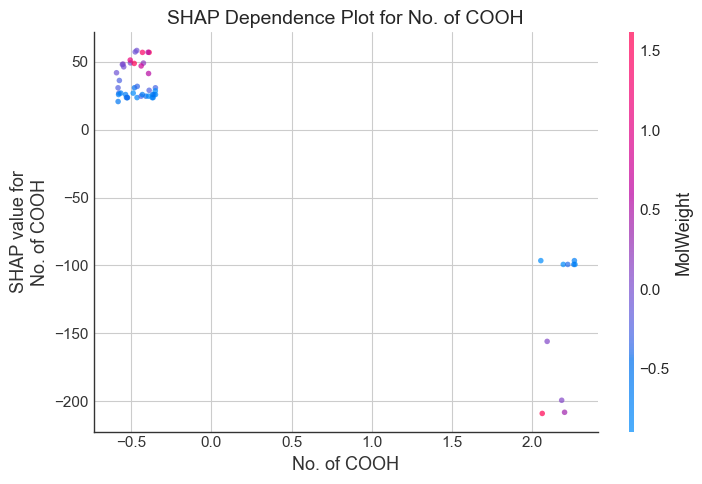

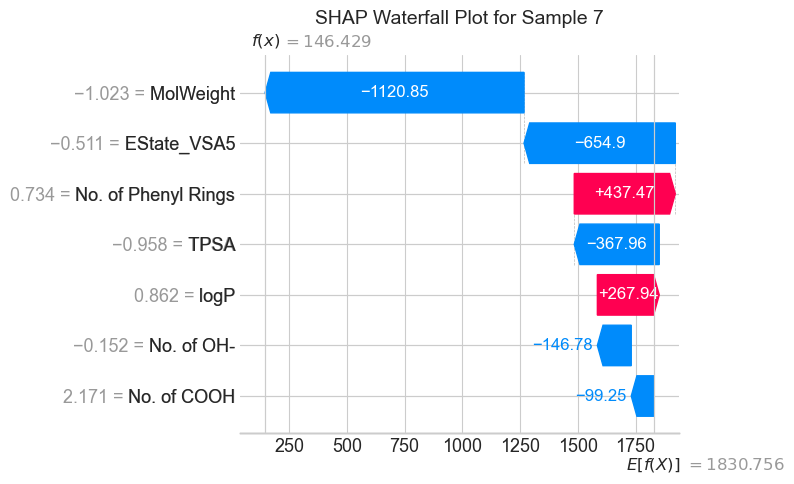

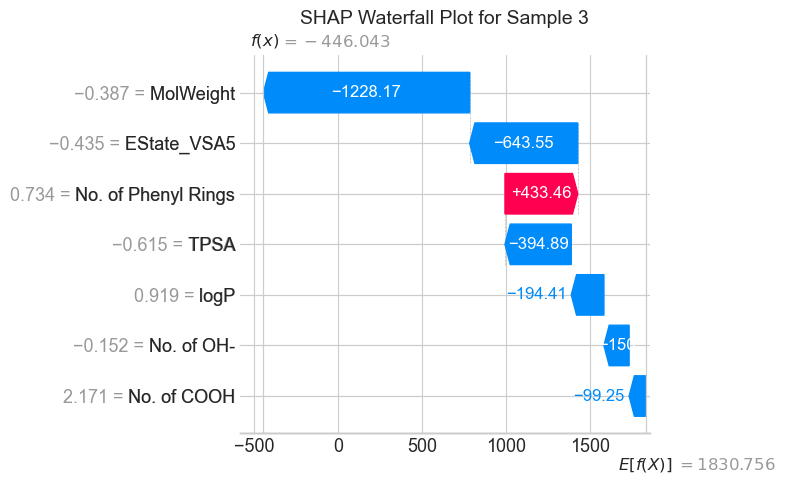

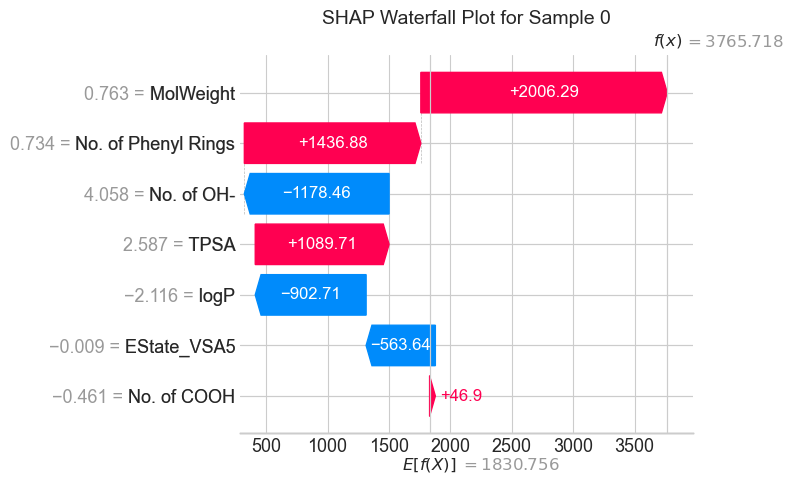


Calculating SHAP interaction values (this may take some time)...


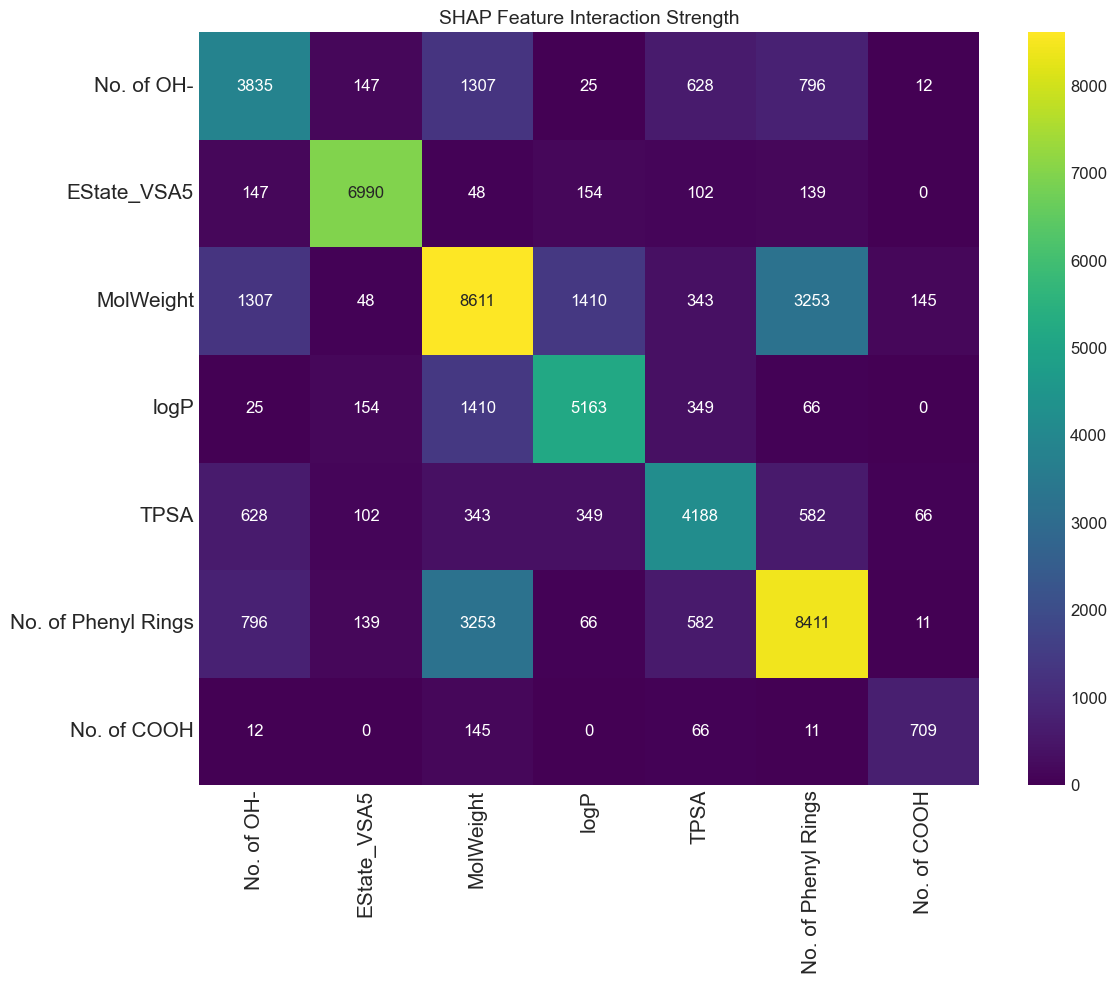

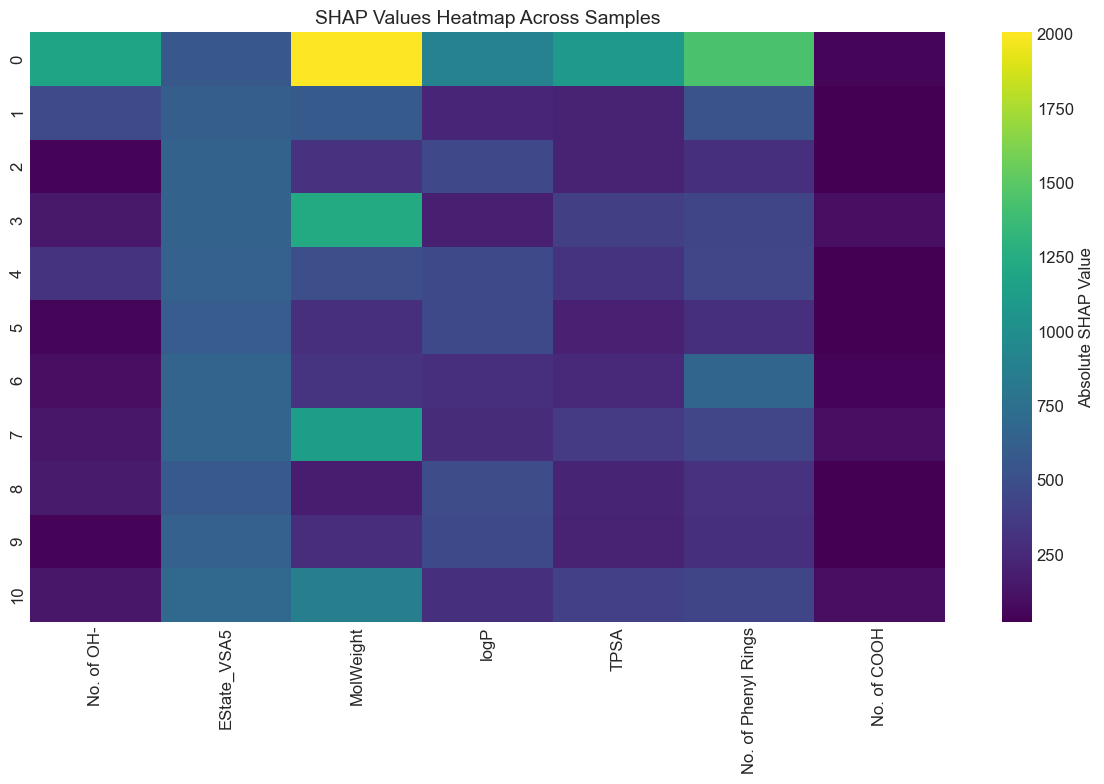


========== ANALYSIS SUMMARY ==========

Feature importance ranking based on SHAP values:
1. MolWeight: 699.3948
2. EState_VSA5: 625.9851
3. No. of Phenyl Rings: 506.9340
4. logP: 409.5499
5. TPSA: 354.4437
6. No. of OH-: 255.1333
7. No. of COOH: 48.8606

Feature impact direction:
- No. of OH- generally decreases Enhancement Factor (mean SHAP: -112.7324)
- EState_VSA5 generally decreases Enhancement Factor (mean SHAP: -625.9851)
- MolWeight generally decreases Enhancement Factor (mean SHAP: -334.6152)
- logP generally decreases Enhancement Factor (mean SHAP: -360.8331)
- TPSA generally decreases Enhancement Factor (mean SHAP: -30.6690)
- No. of Phenyl Rings generally decreases Enhancement Factor (mean SHAP: -9.1977)
- No. of COOH generally decreases Enhancement Factor (mean SHAP: -5.2775)

SHAP Analysis complete. All visualizations have been saved.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# ------------------------------
# 1. CREATE DATASET FROM SPREADSHEET DATA
# ------------------------------
def create_dataset():
    """
    Creates a dataset from the spreadsheet data
    """
    # Data extracted from the spreadsheet image
    data = {
        'ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
               26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 
               49, 50, 51],
        'Name': ['Ibuprofen', 'Dexamethasone', 'Piroxicam', 'Hydrocortisone', 'Albendazole', 'Valsartan', 
                'Nifedipine', 'Nimodipine', 'Carbamazepine', 'Itraconazole', 'Simvastatin', 'Curcumin', 
                'Indomethacin', 'Naproxen', 'Diclofenac', 'Resveratrol', 'Amphotericin B', 'Budesonide', 
                'Cefixime', 'Cefpodoxime', 'Ceftiotur', 'Danazol', 'Ketoconazole', 'Mebendazole', 
                'Metronidazole', 'Paclitaxel', 'Posaconazole', 'Sulfamethoxazole', 'Tinidazole', 
                'Tolbutamide', 'Tropicamide', 'Voriconazole', 'Flurbiprofen', 'Fenofibrate', 
                'Bicalutamide', 'Haloperidol', 'Lamotrigine', 'Glipizide', 'Amlodipine', 'Carvedilol', 
                'Nitrendipine', 'Furosemide', 'Silymarin', 'Biotin', 'Ezetimibe', 'Efonidipine', 
                'Risperidone', 'Miconazole', 'Erythromycin', 'Azithromycin', 'Piperine'],
        'Enhancement Factor': [30, 10, 4.34783, 71.4, 600, 590.783, 44.8, 180, 45.6, 27000, 6, 206, 10, 
                              208.705, 7.5, 36.6667, 150, 38.4091, 23.0263, 2.64315, 72.6667, 0.2217, 
                              151.765, 78, 9.92857, 696.667, 18000, 2.18605, 9.81117, 24029.1, 21.5, 10, 
                              220, 40, 10.0565, 189.32, 14.7059, 9.24324, 3.07167, 166.667, 1250, 2, 12.5, 
                              20, 10, 250, 1.02679, 55, 1.5, 10, 5],
        'No. of OH-': [1, 3, 1, 3, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 3, 11, 2, 2, 0, 1, 1, 0, 0, 0, 4, 1, 0, 
                      0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 5, 10, 2, 0, 1, 0, 5, 5, 0],
        'EState_VSA5': [5.56345, 6.92374, 13.2445, 6.92374, 7.1098, 0, 6.06637, 26.3523, 0, 0, 0, 12.152, 
                        7.1098, 0, 0, 6.06637, 57.7874, 0, 23.218, 18.4051, 36.5813, 11.1462, 17.6962, 0, 
                        6.06637, 24.2655, 34.0363, 24.3959, 18.0892, 45.5122, 0, 6.06637, 6.06637, 25.3089, 
                        25.9802, 12.1327, 0, 6.06637, 0, 0, 12.1327, 0, 19.2425, 12.9901, 0, 0, 0, 0, 13.8475, 
                        20.9573, 6.42082],
        'MolWeight': [206.285, 380.412, 229.217, 298.379, 250.323, 451.527, 374.393, 434.445, 223.231, 
                     559.502, 338.488, 336.387, 343.766, 230.263, 296.153, 228.247, 1037.65, 418.618, 
                     453.458, 416.949, 523.574, 311.425, 358.407, 352.394, 317.301, 1392.41, 700.791, 
                     265.294, 291.354, 425.388, 263.337, 264.303, 196.221, 382.378, 428.86, 371.83, 
                     256.096, 564.712, 364.873, 303.402, 330.34, 278.717, 482.441, 610.521, 469.497, 
                     429.476, 281.396, 271.147, 757.915, 859.094, 285.343],
        'logP': [3.64, 1.14, 3.07, 0.55, 2.9, 4.4, 1.82, 3.1, 2.45, 5.66, 4.68, 3.29, 4.27, 3.18, 3.9, 
               3.1, -0.66, 2.7, -1.4, 2, -2.3, 4.53, 4.35, 2.74, 1.1, 3.5, 3.7, 0.89, 0.1, 2.5, 1.6, 
               1.5, 4.16, 5.24, 2.68, 3.5, 1.9, 0.4, 2.1, 3.98, 3.2, -0.13, 1.16, -1.6, 3.98, 5, 1.3, 
               5.1, -0.24, -0.64, 2.58],
        'TPSA': [37.3, 94.83, 111.47, 94.83, 92.3, 112, 110.45, 120, 46.3, 101, 72.8, 93.1, 68.5, 46.5, 
                49.3, 60.7, 319.6, 93, 158, 134, 174, 37.3, 55.1, 101.4, 69, 221, 112, 89.6, 75.7, 271.2, 
                49.8, 86, 46.8, 52.5, 116.1, 40.5, 82.3, 111.1, 107.8, 75.8, 113, 92.6, 123.5, 271.2, 72.8, 
                105, 44.8, 20.7, 183.1, 224.5, 38.7],
        'No. of Phenyl Rings': [1, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 1, 
                               3, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 3, 2, 1, 3, 1, 2, 0, 0, 1],
        'No. of COOH': [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 
                       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    }
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    print("\nData Preview:")
    print(df.head())
    
    # Extract the specified columns for analysis
    feature_names = [
        'No. of OH-', 'EState_VSA5', 'MolWeight', 
        'logP', 'TPSA', 'No. of Phenyl Rings', 'No. of COOH'
    ]
    
    X = df[feature_names].values
    y = df['Enhancement Factor'].values
    
    # Print basic statistics
    print("\nFeature Statistics:")
    stats_df = pd.DataFrame(X, columns=feature_names).describe()
    print(stats_df)
    
    print("\nTarget (Enhancement Factor) Statistics:")
    print(pd.Series(y).describe())
    
    return X, y, feature_names

# ------------------------------
# 2. DATA PREPARATION
# ------------------------------
def prepare_data(X, y):
    """
    Scales features and splits data into training and test sets.
    """
    # Create scaler
    scaler = StandardScaler()
    
    # Split data before scaling to prevent data leakage
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Fit scaler on training data only
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# ------------------------------
# 3. MODEL TRAINING
# ------------------------------
def train_xgboost_model(X_train, y_train):
    """
    Trains an XGBoost model with hyperparameter tuning.
    """
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'max_depth': randint(2, 6),
        'learning_rate': uniform(0.01, 0.19),
        'n_estimators': randint(50, 250),
        'subsample': uniform(0.6, 0.3),
        'colsample_bytree': uniform(0.6, 0.3),
        'min_child_weight': randint(1, 5),
        'gamma': uniform(0, 0.5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0.5, 1.5)
    }

    # Define cross-validation strategy
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize base XGBoost model
    xgb_base = XGBRegressor(
        objective='reg:squarederror', 
        random_state=42,
        tree_method='exact',  # exact for small datasets
        importance_type='gain'  # 'gain' is generally better than 'weight'
    )

    # Set up RandomizedSearchCV
    print("\nPerforming hyperparameter tuning...")
    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_distributions,
        n_iter=20,  # number of parameter settings sampled
        scoring='neg_mean_squared_error',  # negative MSE as the scoring metric
        cv=kfold,
        random_state=42,
        n_jobs=-1,
        verbose=1,
        refit=True  # refit the best model on the entire training data
    )

    # Fit the random search
    random_search.fit(X_train, y_train)
    
    # Get best model
    best_model = random_search.best_estimator_
    
    print("\nBest Hyperparameters:")
    for param, value in random_search.best_params_.items():
        print(f"{param}: {value}")
        
    print(f"\nBest CV MSE: {-random_search.best_score_:.4f}")
    print(f"Best CV RMSE: {np.sqrt(-random_search.best_score_):.4f}")
    
    return best_model

# ------------------------------
# 4. MODEL EVALUATION
# ------------------------------
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates the model on training and test sets.
    """
    # Predict on training set
    y_train_pred = model.predict(X_train)
    
    # Predict on test set
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics for training set
    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Calculate metrics for test set
    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Print results
    print("\nTraining Set Metrics:")
    print(f"  R²:   {train_r2:.4f}")
    print(f"  MSE:  {train_mse:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE:  {train_mae:.4f}")
    
    print("\nTest Set Metrics:")
    print(f"  R²:   {test_r2:.4f}")
    print(f"  MSE:  {test_mse:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE:  {test_mae:.4f}")
    
    # Visualize actual vs predicted values
    plt.figure(figsize=(8, 8))
    
    # Plot training data
    plt.scatter(y_train, y_train_pred, color='blue', alpha=0.6, label='Training')
    
    # Plot test data
    plt.scatter(y_test, y_test_pred, color='red', alpha=0.6, label='Test')
    
    # Plot perfect prediction line
    min_val = min(min(y_train), min(y_test))
    max_val = max(max(y_train), max(y_test))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Fit')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Actual Enhancement Factor')
    plt.ylabel('Predicted Enhancement Factor')
    plt.title('XGBoost: Actual vs. Predicted Enhancement Factor')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return y_test_pred

# ------------------------------
# 5. IMPROVED SHAP ANALYSIS
# ------------------------------
def perform_shap_analysis(model, X_train, X_test, feature_names):
    """
    Performs comprehensive SHAP analysis for model interpretation with improved visualizations.
    """
    print("\nPerforming SHAP analysis...")
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values for the test set and train set (for more data points)
    shap_values_test = explainer.shap_values(X_test)
    
    # For better density in plots, combine train and test data
    # This gives more data points for more meaningful visualizations
    X_combined = np.vstack([X_train, X_test])  # Use all data for better density
    shap_values_combined = explainer.shap_values(X_combined)
    
    # 1. Summary Plot (Feature Importance with Direction) - Using combined dataset
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values_combined, 
        X_combined, 
        feature_names=feature_names, 
        alpha=0.8,       # Increased opacity
        show=False,
        plot_size=(12, 8)
    )
    plt.title('SHAP Feature Importance for Enhancement Factor Prediction', fontsize=14)
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. SHAP Beeswarm plot with violin visualization
    # This shows distribution density better than scattered points
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values_combined, 
        X_combined,
        feature_names=feature_names,
        plot_type="violin",  # Change to violin for density visualization
        show=False
    )
    plt.title('SHAP Feature Importance Distribution', fontsize=14)
    plt.tight_layout()
    plt.savefig('shap_violin_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Bar Plot (Feature Importance)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_combined, 
        X_combined, 
        feature_names=feature_names, 
        plot_type='bar', 
        show=False
    )
    plt.title('SHAP Mean Absolute Impact on Enhancement Factor', fontsize=14)
    plt.tight_layout()
    plt.savefig('shap_feature_importance_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Individual Feature Dependence Plots with more context
    # Create dependence plots for each feature with clearer interaction visualization
    for i, feature in enumerate(feature_names):
        plt.figure(figsize=(10, 6))
        # Detect potential interaction features for more insightful plots
        interaction_index = "auto"  # Let SHAP detect the strongest interaction
        shap.dependence_plot(
            i, 
            shap_values_combined, 
            X_combined, 
            feature_names=feature_names,
            interaction_index=interaction_index,
            alpha=0.7,  # More visible points
            x_jitter=0.1,  # Add slight jitter to see overlapping points better
            show=False
        )
        plt.title(f'SHAP Dependence Plot for {feature}', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'shap_dependence_{feature.replace(" ", "_").replace(".", "")}.png', 
                  dpi=300, bbox_inches='tight')
        plt.show()
    
    # 5. Waterfall plots for individual sample explanations
    try:
        # Choose samples with interesting SHAP values
        sample_indices = np.argsort(np.abs(shap_values_test).sum(axis=1))[-3:]  # Top 3 most impacted samples
        
        for idx in sample_indices:
            plt.figure(figsize=(10, 8))
            shap.plots.waterfall(
                shap.Explanation(
                    values=shap_values_test[idx], 
                    base_values=explainer.expected_value, 
                    data=X_test[idx], 
                    feature_names=feature_names
                ),
                max_display=len(feature_names),
                show=False
            )
            plt.title(f'SHAP Waterfall Plot for Sample {idx}', fontsize=14)
            plt.tight_layout()
            plt.savefig(f'shap_waterfall_plot_sample_{idx}.png', dpi=300, bbox_inches='tight')
            plt.show()
    except Exception as e:
        print(f"Couldn't create waterfall plot: {e}")
    
    # 6. SHAP Interaction Values (Feature Interactions)
    try:
        print("\nCalculating SHAP interaction values (this may take some time)...")
        shap_interaction = explainer.shap_interaction_values(X_test)
        
        # Plot summary of interactions
        plt.figure(figsize=(12, 10))
        
        # Get the sum of all interaction values for each feature pair
        interaction_matrix = np.abs(shap_interaction).sum(0)
        
        # Create a DataFrame for better visualization
        df_interaction = pd.DataFrame(
            interaction_matrix, 
            index=feature_names, 
            columns=feature_names
        )
        
        # Create heatmap of interactions
        sns.heatmap(
            df_interaction, 
            cmap='viridis', 
            annot=True, 
            fmt='.0f'
        )

        plt.xticks(fontsize=15)  # Adjust x-axis labels
        plt.yticks(fontsize=15)  
        plt.title('SHAP Feature Interaction Strength', fontsize=14)
        plt.tight_layout()
        plt.savefig('shap_interaction_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Couldn't compute interaction values: {e}")
    
    # 7. SHAP Heatmap across samples
    # This visualization helps identify patterns across samples
    try:
        plt.figure(figsize=(12, 8))
        
        # Get absolute SHAP values for better visualization
        abs_shap_values = np.abs(shap_values_test)
        
        # Create a dataframe with SHAP values
        shap_df = pd.DataFrame(abs_shap_values, columns=feature_names)
        
        # Create heatmap 
        sns.heatmap(
            shap_df,
            cmap='viridis',
            annot=False,
            cbar_kws={'label': 'Absolute SHAP Value'}
        )
        plt.title('SHAP Values Heatmap Across Samples', fontsize=14)
        plt.tight_layout()
        plt.savefig('shap_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Couldn't create SHAP heatmap: {e}")
    
    return shap_values_test, explainer

# ------------------------------
# 6. FEATURE IMPORTANCE VISUALIZATION
# ------------------------------
def visualize_feature_importance(model, feature_names):
    """
    Visualizes XGBoost's native feature importance.
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a dictionary of feature importances
    feature_importance = dict(zip(feature_names, importances))
    
    # Sort features by importance
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    
    # Extract feature names and importance values
    features, importance = zip(*sorted_features)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(features)), importance, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importance')
    plt.title('XGBoost Feature Importance (gain)')
    plt.tight_layout()
    plt.savefig('xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# ------------------------------
# 7. MAIN FUNCTION
# ------------------------------
def main():
    """
    Main function to run the entire analysis pipeline.
    """
    print("Starting XGBoost SHAP Analysis for Molecular Enhancement Factor Prediction")
    
    # 1. Create dataset from the spreadsheet data
    X, y, feature_names = create_dataset()
    
    # 2. Prepare data
    X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_data(X, y)
    
    # 3. Train model
    model = train_xgboost_model(X_train_scaled, y_train)
    
    # 4. Evaluate model
    y_test_pred = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    
    # 5. XGBoost native feature importance
    visualize_feature_importance(model, feature_names)
    
    # 6. SHAP analysis with improved visualizations
    shap_values, explainer = perform_shap_analysis(model, X_train_scaled, X_test_scaled, feature_names)
    
    # 7. Print summary of findings
    print("\n========== ANALYSIS SUMMARY ==========")
    
    # Calculate absolute mean SHAP values for each feature
    mean_abs_shap = np.abs(shap_values).mean(0)
    feature_importance = dict(zip(feature_names, mean_abs_shap))
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    
    print("\nFeature importance ranking based on SHAP values:")
    for i, (feature, importance) in enumerate(sorted_features, 1):
        print(f"{i}. {feature}: {importance:.4f}")
    
    # Calculate mean SHAP values to identify direction of impact
    mean_shap = shap_values.mean(0)
    feature_effects = dict(zip(feature_names, mean_shap))
    
    print("\nFeature impact direction:")
    for feature, effect in feature_effects.items():
        direction = "increases" if effect > 0 else "decreases"
        print(f"- {feature} generally {direction} Enhancement Factor (mean SHAP: {effect:.4f})")
    
    print("\nSHAP Analysis complete. All visualizations have been saved.")

if __name__ == "__main__":
    main()